In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix,ConfusionMatrixDisplay,auc, roc_curve
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [4]:
np.random.seed(42)

In [5]:
DATA_FOLDER = '../data/advertising.csv'

data = pd.read_csv(DATA_FOLDER)

In [9]:
data.sample(3)

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
612,75.19,31,33502.57,245.76,Implemented discrete frame,Johnstonshire,1,Tajikistan,2016-06-16 18:04:51,0
468,65.59,47,28265.81,121.81,Digitized disintermediate ability,Brandymouth,0,Indonesia,2016-03-22 06:41:38,1
355,87.09,36,57737.51,221.98,Synergized coherent interface,Luischester,1,Reunion,2016-04-21 16:10:50,0


In [10]:
X = data.drop(columns=['Clicked on Ad', 'Timestamp'])
y = data['Clicked on Ad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
def accuracy_metrics(model):
    
    y_pred = model.predict(X_test)
    
    print("Accuracy is", accuracy_score(y_test, y_pred))
    print("Precision is", precision_score(y_pred, y_test))
    print("Recall is", recall_score(y_test, y_pred))
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(conf_matrix)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
    disp.plot(cmap='Blues')

In [12]:
def roc_auc(model):

    if hasattr(model, "predict_proba"):
        # Use probabilities for the positive class--> for models like Random Forest and Gradient Boosting
        y_prob = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        # Use decision scores for models like SVC   
        y_prob = model.decision_function(X_test)
    else:
        raise ValueError("The provided model does not support predict_proba or decision_function.")
    
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc_score = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()


In [13]:
def feature_imp(model, model_step_name):

    rf_model = model.named_steps[model_step_name]

    importances = rf_model.feature_importances_
    feature_names = X_train.columns

    feature_importances = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })

    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')
    plt.title('Feature Importances from Random Forest', fontsize=16)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.show()

In [16]:
trf1 = ColumnTransformer([
    ('ordinal_encode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),[4, 5, 7])
], remainder='passthrough')
# [4, 5, 7] are the categorical columns --> Ad Topic Line, City, Country 

In [17]:
trf2 = ColumnTransformer([
    ('scaling', MinMaxScaler(), slice(0, 8))
])

In [18]:
trf3 = RandomForestClassifier()

In [19]:
pipe = Pipeline([
    ('trf1', trf1),
    ('trf2', trf2),
    ('trf3', trf3)
])

In [21]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('trf1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal_encode',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  [4, 5, 7])])),
                ('trf2',
                 ColumnTransformer(transformers=[('scaling', MinMaxScaler(),
                                                  slice(0, 8, None))])),
                ('trf3', RandomForestClassifier())])

In [22]:
pipe.predict(X_test)

array([1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 1])

In [28]:
pipe.predict_proba(X_test)
# gives 2 values--> first one is the 0th class probability and the 2nd one is first class probability

array([[0.1 , 0.9 ],
       [0.04, 0.96],
       [0.02, 0.98],
       [0.17, 0.83],
       [0.93, 0.07],
       [0.43, 0.57],
       [0.92, 0.08],
       [0.03, 0.97],
       [0.88, 0.12],
       [0.02, 0.98],
       [0.88, 0.12],
       [0.04, 0.96],
       [0.01, 0.99],
       [0.9 , 0.1 ],
       [0.11, 0.89],
       [0.02, 0.98],
       [0.01, 0.99],
       [0.1 , 0.9 ],
       [0.91, 0.09],
       [0.04, 0.96],
       [0.95, 0.05],
       [0.12, 0.88],
       [0.02, 0.98],
       [0.79, 0.21],
       [0.92, 0.08],
       [0.04, 0.96],
       [0.76, 0.24],
       [0.98, 0.02],
       [0.02, 0.98],
       [0.05, 0.95],
       [0.77, 0.23],
       [0.28, 0.72],
       [0.86, 0.14],
       [0.09, 0.91],
       [0.01, 0.99],
       [0.94, 0.06],
       [0.93, 0.07],
       [0.24, 0.76],
       [0.11, 0.89],
       [0.04, 0.96],
       [0.87, 0.13],
       [0.02, 0.98],
       [0.56, 0.44],
       [0.01, 0.99],
       [0.87, 0.13],
       [0.82, 0.18],
       [0.15, 0.85],
       [0.01,

In [29]:
trf4 = SVC()

In [32]:
pipe2 = Pipeline([
    ('trf1', trf1),
    ('trf2', trf2),
    ('trf4', trf4)
])

In [33]:
pipe2.fit(X_train, y_train)

Pipeline(steps=[('trf1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal_encode',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  [4, 5, 7])])),
                ('trf2',
                 ColumnTransformer(transformers=[('scaling', MinMaxScaler(),
                                                  slice(0, 8, None))])),
                ('trf4', SVC())])

In [34]:
pipe2.predict(X_test)

array([1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 1])

In [42]:
pipe2.decision_function(X_test)
# positive--> predicted as class 1
# negative--> predicted as class 0
# Larger magnitude means higher confidence in prediction

array([ 0.44281831,  1.26452807,  1.33701777,  1.01616919, -1.34375807,
       -0.29917858, -1.49861363,  1.53445668, -1.09502893,  1.54115144,
       -1.17545692,  1.15421484,  1.64705473, -1.13437093,  1.21556776,
        1.61687024,  1.56864556,  1.39877598, -0.82417716,  1.59522426,
       -1.32562182,  1.20209564,  1.27549422, -0.79026344, -1.75810745,
        2.00921372, -0.89248779, -2.02180365,  2.47569814,  1.47797094,
       -0.69423909, -0.34269519, -1.62681952,  1.18146322,  1.61125472,
       -1.48918949, -1.60689474, -0.19270941,  0.80093026,  1.47711525,
       -1.06379533,  1.16007919, -0.18034741,  1.41157554, -1.38437748,
       -1.16285608,  0.50634039,  1.37546193, -0.40113233,  1.12635065,
        1.35141432, -0.83011225,  1.42841097, -1.30582599, -1.94883549,
       -0.99371258, -1.11324657,  1.73186315, -1.13519648,  1.71423424,
       -1.0452395 ,  1.16010238, -0.79070947,  1.43632962,  1.04987745,
        0.81829369,  1.47906993, -1.61639359,  1.24932721,  0.92

In [45]:
fpr, tpr, thresholds = roc_curve(y_test, pipe.predict_proba(X_test)[:,1])

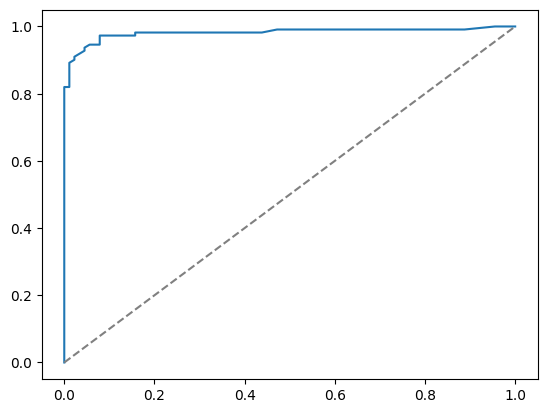

In [49]:
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line

# Basic outline